In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#tensorboard --logdir 'runs\LSTM_pytorch_full' --host localhost --port 8888
report_folder = 'LSTM_pytorch_full'
from IPython.display import clear_output
clear_output()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
clear_output()

# Solved case using pytorch [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer.
* Model reads sequence and predicts next entry.
* Can predict further by updating sequence with previous prediction and reusing model.
## Read data & (OPTIONAL) check trends



torch.Size([132, 3])

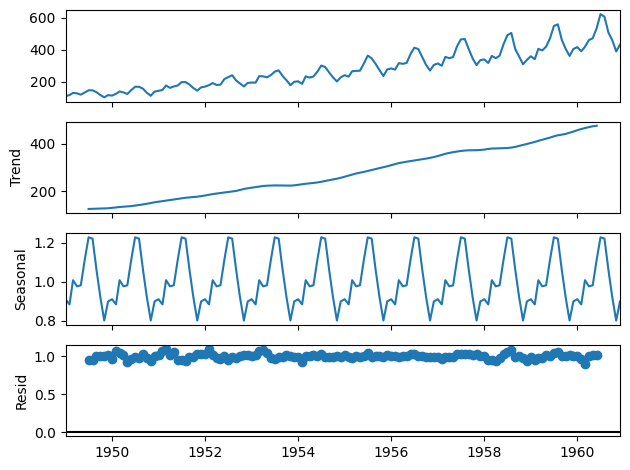

In [4]:
df = pd.read_csv(os.path.join('data_processing','media','airline-passengers.csv'), index_col=0, parse_dates=True)
timeseriesOG    = torch.tensor(df["Passengers"].values, dtype = torch.float, device=device).reshape(-1,1)
result          = seasonal_decompose(df, model='multiplicative')
result.plot();

data_trend      = result.trend.to_numpy()[6:-6]
data_seasonal   = result.seasonal.to_numpy()[6:-6]
data_residual   = result.resid.to_numpy()[6:-6]
LEN_DATA = len(data_trend)

data_trend      = torch.tensor(data_trend   , device = device, dtype = torch.float)
data_seasonal   = torch.tensor(data_seasonal, device = device, dtype = torch.float)
data_residual   = torch.tensor(data_residual, device = device, dtype = torch.float)
data_concat     = torch.vstack([data_trend,data_seasonal,data_residual]).T
data_concat.shape

## Prepare training and "validaion" slices of data

For training $\rightarrow$ 1 step ahead.
* slice(from, to, step), 'to' not included
* get all data except last element

In [5]:
LOOKBACK = 30
slices_train = [slice(i,i + LOOKBACK,1) for i in range(LEN_DATA - LOOKBACK + 1)]
NUM_SLICES = len(slices_train)
slices_train[-1], data_trend.shape, data_trend[slices_train[-1]].shape

(slice(102, 132, 1), torch.Size([132]), torch.Size([30]))

For testing `N_FORWARD` steps ahead.
* get up to last `N_FORWARD` entries
* generate input slice and output slice

In [6]:
N_FORWARD = 10
slices_test_input    = [slice(i              , i + LOOKBACK              , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_output   = [slice(i + LOOKBACK   , i + LOOKBACK + N_FORWARD  , 1) for i in range(LEN_DATA - LOOKBACK + 1 - N_FORWARD)]
slices_test_input[-1], slices_test_output[-1]

(slice(92, 122, 1), slice(122, 132, 1))

C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_11540\3024994491.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  batch_x = torch.tensor([train_data[sl       ] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1)


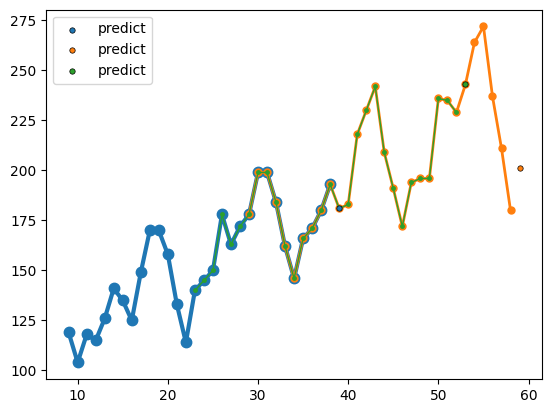

In [7]:
torch.manual_seed(7)
train_data = df["Passengers"].values
# last slice has no prediction
batch_x = torch.tensor([train_data[sl       ] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1) 
batch_y = torch.tensor([train_data[[sl.stop]] for sl in slices_train[:-1]], dtype=torch.float).to(device).unsqueeze(-1)
batch_x.shape, batch_y.shape
#ID_shuffle      = torch.randperm(batch_x.size(0))
ID_shuffle = torch.arange(batch_x.size(0))
batch_x_shuffle = batch_x[ID_shuffle]
batch_y_shuffle = batch_y[ID_shuffle]
sc = 1
#plt.plot(train_data)
P = 3
s = 1
i1 = range(P)
i2 = torch.arange(P,0,-1)*s
gg =  torch.randperm(batch_x.size(0))[:P]
for k,size,g in zip(i1,i2,gg):
   
    x_from = ID_shuffle[g]
    x = range(x_from, x_from + batch_x.shape[1],1)
    p = plt.plot(x, batch_x_shuffle[g].cpu().numpy(), '.', ms = 5*size)
    c = p[0].get_color()
    plt.plot(x, batch_x_shuffle[g].cpu().numpy(), '-', c= c, lw = size)
    plt.scatter([x_from + batch_x.shape[1]], batch_y_shuffle[g].cpu().numpy(),
                c= c,edgecolor ='k',linewidths= 0.5, s=15, zorder = 10, label ='predict')
plt.legend()

## Models
### Training loop

In [53]:
def train(model,
          model_name,
          criterion,
          optimizer,
          saved_state_path,
          saved_state_iters     = 999,
          minibatches           = False,
          minbatch_size         = 50,
          NUM_EPOCHS            = 40_000,
          iters_tot             = 0,
          loss_last_N           = 10,
          loss_lower_than       = 100,
          loss_report_interval  = 100,
          eval_interval         = 2500,
          folder_report         = report_folder,
          dtype                 = torch.float):
    early_break = False
    loss_all = []

    def train_iter(x, y):
        output  = model(x)[0]        # [1, minibatch, features]
        y       = y.view(1,-1,1)     # remap [minibatch, feats, 1] to output dims
        loss    = criterion(output, y)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    # TENSORBOARD
    time_now    = datetime.datetime.now().strftime("%H_%M_%S") + "_" + str(model_name)
    writer      = SummaryWriter(os.path.join('runs', folder_report, time_now))

    for i in range(NUM_EPOCHS):
        ID_shuffle      = torch.randperm(batch_x.size(0))
        batch_x_shuffle = batch_x[ID_shuffle].to(dtype)
        batch_y_shuffle = batch_y[ID_shuffle].to(dtype)
        loss_total = 0
        if minibatches:
            minbatches_x = torch.split(batch_x_shuffle, minbatch_size, dim=0)
            minbatches_y = torch.split(batch_y_shuffle, minbatch_size, dim=0)
            for x,y in zip(minbatches_x, minbatches_y):
                loss_total += train_iter(x, y)
        else: 
            loss_total += train_iter(batch_x_shuffle, batch_y_shuffle)  

        # LOSS
        loss_all.append(loss_total)
        if i > loss_last_N and max(loss_all[-loss_last_N:]) < loss_lower_than: early_break = True

        writer.add_scalar('Training Loss', loss_total, global_step=iters_tot)

        # EVAL
        last_iter = i == NUM_EPOCHS - 1
        if i % eval_interval == 0 or early_break or last_iter:#and i > 0:
            model.eval()
            clear_output()
            s = torch.randint(0, len(slices_test_input) - 1, size = (1,)).item()
            x = torch.tensor([train_data[slices_test_input [s]]], dtype=dtype, device=device).to(device).reshape(1,-1,1) 
            y = torch.tensor([train_data[slices_test_output[s]]], dtype=dtype, device=device).to(device).reshape(1,-1,1) 
            model.test(x, y)
            plt.suptitle(f'{iters_tot = }, {i =}')
            plt.show()
            model.train()
        
        iters_tot += 1

        if (i % loss_report_interval == 0 or early_break or last_iter) and i > 1:
            last_losses = [f"{x:0.2e}" for x in loss_all[-5:]]
            last_losses = '[' + ", ".join([f"{x:<8}" for x in last_losses]) + ']'
            print(f'{iters_tot = :<{len(str(NUM_EPOCHS))}}; {i = :<{len(str(NUM_EPOCHS))}}; last 5 loss values: {last_losses}, {minibatches = }')

        
        if (i % saved_state_iters == 0 and i > 1) or early_break or last_iter:
            torch.save(model.state_dict(), saved_state_path)

        if early_break: break
        
    return iters_tot

### PYTORCH: batched model

In [17]:
class LSTM(nn.Module):

    def __init__(self, num_features, hidden_dim, batch_first = True): 
        super().__init__()
        self.hidden_size = hidden_dim
        self.num_features = num_features
        self.batch_first  = batch_first
        self.lstm = nn.LSTM(num_features, hidden_dim, batch_first=batch_first)
        self.lin  = nn.Linear(hidden_dim, num_features)
        self.report_dims = True

    def forward(self,  data):
        
        N = data.size(0) if self.batch_first else data.size(1)
        h,c = self.lstm(data)[1]
        out = self.lin(h)
        if self.report_dims: self.report(data, h, c, out)
        return  out, (h,c) 
    
    def report(self, data , h, c, out):
        print(f'{data.shape = }, {h.shape = }, {c.shape = }, {out.shape = }')
        self.report_dims = False


    @torch.no_grad()
    def test(self, x, y):
        """ Do one seq lstm run. Shift old seq to left and append prediction. REPEAT with zero c&h = default"""
        N = x.size(0) if self.batch_first else x.size(1)
        x1 = x.clone()
        _, states_out = self.lstm(x1) 
        x_next = self.lin(states_out[0])

        predict = torch.zeros(size = (N, N_FORWARD + 1, self.num_features))
        predict[0,0] = x_next[0,0]

        for i in range(N_FORWARD):
            x1[:,:-1]        = x1[:,1:].clone()
            x1[:,-1]         = x_next[0]
            _, states_out   = self.lstm(x1)
            x_next          = self.lin(states_out[0])
            predict[0   ,i+1] = x_next[0,0]

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , x.flatten().cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), y.flatten()   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict.flatten()[:-1].cpu().numpy(), c='blue' , label = 'Predict')

#### PYTORCH training: model with batch = 20: ~ 17k iters ~ 5 min training


In [31]:
HIDDEN_SIZE = 100
saved_state_path = os.path.join('data_processing',
                                'neural_networks', 
                                'save_states', 
                                'LSTM', 
                                f'pytorch_LSTM_B20_H{HIDDEN_SIZE}.pht')

LSTB_Batched_20 = LSTM(1, HIDDEN_SIZE).to(device)

load_weights = False
if os.path.exists(saved_state_path) and load_weights:
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_20.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(LSTB_Batched_20.parameters(), lr = 1e-4)#, weight_decay=1e-5)
iters_tot = 0

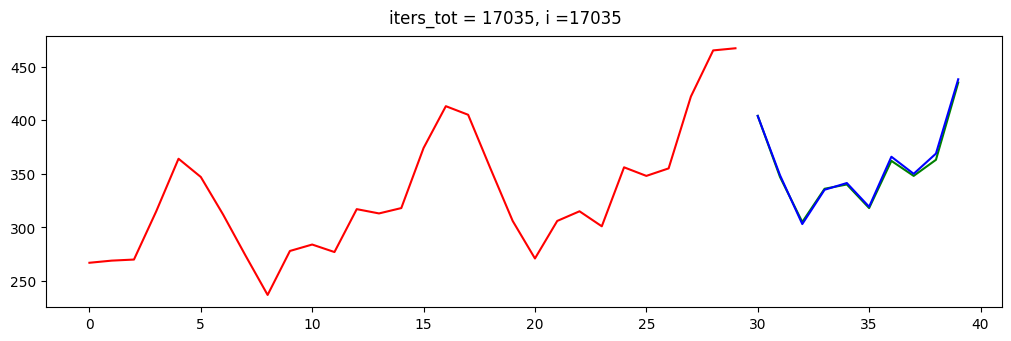

iters_tot = 17036; i = 17035; last 5 loss values: [9.66e+01, 9.73e+01, 9.69e+01, 9.65e+01, 9.69e+01], minibatches = True


In [32]:
iters_tot = train(  model               = LSTB_Batched_20,
                    model_name          = 'pytorch_batch_20',
                    criterion           = criterion,
                    optimizer           = optimizer,
                    saved_state_path    = saved_state_path,
                    saved_state_iters   = 999,
                    minibatches         = True,
                    minbatch_size       = 20,
                    NUM_EPOCHS          = 80_000,
                    iters_tot           = iters_tot,
                    loss_last_N         = 10,
                    loss_lower_than     = 100,
                    loss_report_interval= 200,
                    eval_interval       = 2_500,
                    folder_report       = report_folder)

#### PYTORCH training: model with batch = 70: ~ 32 k iter ~ 4.5 min training

In [27]:
saved_state_path = os.path.join('data_processing',
                                'neural_networks', 
                                'save_states', 
                                'LSTM', 
                                f'pytorch_LSTM_B70_H{HIDDEN_SIZE}.pht')

LSTB_Batched_70 = LSTM(1, HIDDEN_SIZE).to(device)

load_weights = False
if os.path.exists(saved_state_path) and load_weights:
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_70.load_state_dict(saved_state_dict)

optimizer = Adam(LSTB_Batched_70.parameters(), lr = 1e-4)
iters_tot = 0

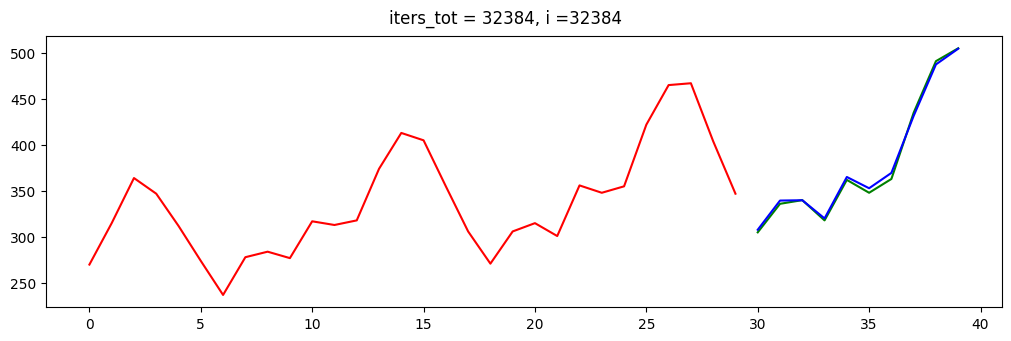

iters_tot = 32385; i = 32384; last 5 loss values: [6.89e+01, 6.77e+01, 7.04e+01, 9.58e+01, 7.65e+01], minibatches = True


In [28]:
iters_tot = train(  model               = LSTB_Batched_70,
                    model_name          = 'pytorch_batch_70',
                    criterion           = criterion,
                    optimizer           = optimizer,
                    saved_state_path    = saved_state_path,
                    saved_state_iters   = 999,
                    minibatches         = True,
                    minbatch_size       = 70,
                    NUM_EPOCHS          = 80_000,
                    iters_tot           = iters_tot,
                    loss_last_N         = 10,
                    loss_lower_than     = 100,
                    loss_report_interval= 200,
                    eval_interval       = 2_500,
                    folder_report       = report_folder)

#### PYTORCH training: model with mono batch ~ 60k iters ~6 min training

In [19]:
saved_state_path = os.path.join('data_processing',
                                'neural_networks', 
                                'save_states', 
                                'LSTM', 
                                f'pytorch_LSTM_BALL_H{HIDDEN_SIZE}.pht')

LSTB_Batched_all = LSTM(batch_x.size(2), HIDDEN_SIZE).to(device)

load_weights = False
if os.path.exists(saved_state_path) and load_weights:
    saved_state_dict = torch.load(saved_state_path)
    LSTB_Batched_all.load_state_dict(saved_state_dict)

criterion = nn.MSELoss()
optimizer = Adam(LSTB_Batched_all.parameters(), lr = 1e-4)#, weight_decay=1e-5)
iters_tot = 0

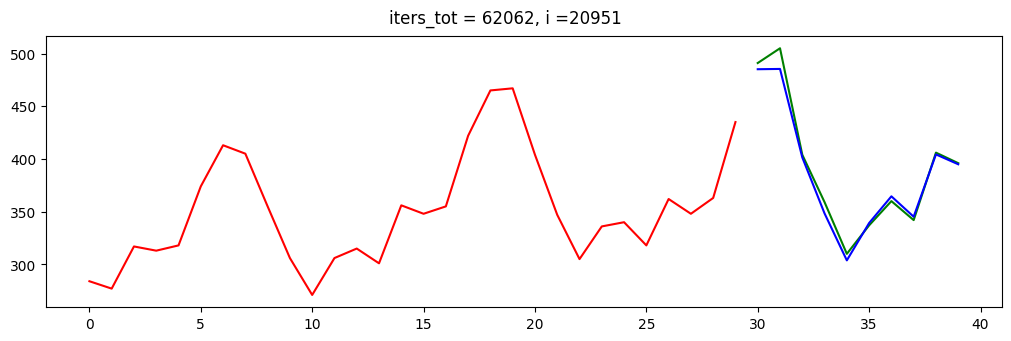

iters_tot = 62063; i = 20951; last 5 loss values: [9.98e+01, 9.98e+01, 9.98e+01, 9.98e+01, 9.97e+01], minibatches = False


In [23]:
iters_tot = train(  model               = LSTB_Batched_all,
                    model_name          = 'pytorch_batch_all',
                    criterion           = criterion,
                    optimizer           = optimizer,
                    saved_state_path    = saved_state_path,
                    saved_state_iters   = 999,
                    minibatches         = False,
                    minbatch_size       = 50,
                    NUM_EPOCHS          = 1,
                    iters_tot           = iters_tot,
                    loss_last_N         = 10,
                    loss_lower_than     = 100,
                    loss_report_interval= 200,
                    eval_interval       = 2_500,
                    folder_report       = report_folder)

### CUSTOM PYTORCH FORWARD: batched model

In [59]:
class FakeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.num_features = input_size
        self.hidden_size  = hidden_size

        self.Wi         = nn.Linear(in_features=input_size  , out_features=4*hidden_size, bias=False, device=device, dtype=torch.double)
        self.Wh         = nn.Linear(in_features=hidden_size , out_features=4*hidden_size, bias=True , device=device, dtype=torch.double)

        self.sigmoid    = nn.Sigmoid()
        self.tanh       = nn.Tanh()

        self.lin        = nn.Linear(hidden_size, input_size, dtype=torch.double)
        self.batch_first = True
        self.batch_size = 1
    
    def LSTM_PASS(self, x_t, hc = None):
        #N = batch size; F - input size (features); H - hidden size
        if hc is None:
            h_prev, c_prev = torch.zeros((2,1, self.batch_size, self.hidden_size), device=device, dtype=torch.double)
        else: 
            h_prev, c_prev = hc

        # [1, N, 4*H] = [1, N, F] x [F, 4*H] + [1, N, H] x [H, 4*H]
        gates = self.Wi(x_t.to(torch.double)) + self.Wh(h_prev)
        # [1, N, H], [1, N, H], [1, N, H], [1, N, H]
        gate_input, gate_forget, gate_cell, gate_output = gates.chunk(4, dim = 2) #[1, L, 4*H] -> 4x

        gate_input  = self.sigmoid(  gate_input )
        gate_forget = self.sigmoid(  gate_forget)
        gate_cell   = self.tanh(     gate_cell  )
        gate_output = self.sigmoid(  gate_output)

        c_t         = gate_forget * c_prev + gate_input * gate_cell
        h_t         = gate_output * self.tanh(gate_cell)

        # [1, L, NUM_HIDD], [1, L, NUM_HIDD]
        return  h_t, c_t
    
    def forward(self, dataset):
        BATCH_SIZE   = self.batch_size   = dataset.size(0)
        NUM_FEATURES = self.num_features

        history_ch   = [None]
        hc = None
        for x_t in dataset.unbind(dim=1):       # [batch, feature]
            hc = history_ch[-1]
            h_t, c_t = self.LSTM_PASS(x_t.view(1,BATCH_SIZE,NUM_FEATURES), hc)
            history_ch.append((h_t, c_t))

        final = self.lin(h_t)
        return final, hc
    
    # @torch.no_grad()
    # def test(self, x, y): # OG test func for custom LSMT. replaced for now.
    #     """ Do one seq lstm run. Shift old seq to left and append prediction. REPEAT with zero c&h = default"""
    #     N = x.size(0) if self.batch_first else x.size(1)
    #     x_t = x.clone()
    #     predict = torch.zeros(size = (N, N_FORWARD, self.num_features))

    #     for i in range(N_FORWARD):
    #         x_next   = self.forward(x_t)[0] 
    #         predict[0 ,i]       = x_next[0,0]
    #         x_t[:,:-1]          = x_t[:,1:].clone()
    #         x_t[:,-1]           = x_next[0]

    #     fig, ax = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
    #     ax.plot(range(LOOKBACK)                     , x         .flatten().cpu().numpy(), c='red'  , label = 'True prev')
    #     ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), y         .flatten().cpu().numpy(), c='green', label = 'True post')
    #     ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict   .flatten().cpu().numpy(), c='blue' , label = 'Predict')

    @torch.no_grad()
    def test(self, x, y):
        """ Do one seq lstm run. Shift old seq to left and append prediction. REPEAT with zero c&h = default"""
        N = x.size(0) if self.batch_first else x.size(1)
        x1 = x.clone()
        x_next   = self.forward(x1)[0] 

        predict = torch.zeros(size = (N, N_FORWARD + 1, self.num_features))
        predict[0,0] = x_next[0,0]

        for i in range(N_FORWARD):
            x1[:,:-1]        = x1[:,1:].clone()
            x1[:,-1]         = x_next[0]
            x_next   = self.forward(x1)[0]
            predict[0   ,i+1] = x_next[0,0]

        fig, axs = plt.subplots(self.num_features, 1, figsize = (10,3.3), layout='constrained')
        axs = [axs] if self.num_features == 1 else axs
        for k, ax in enumerate(axs):
            ax.plot(range(LOOKBACK)                     , x.flatten().cpu().numpy(), c='red'  , label = 'True prev')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), y.flatten()   .cpu().numpy(), c='green', label = 'True post')
            ax.plot(range(LOOKBACK, LOOKBACK+ N_FORWARD), predict.flatten()[:-1].cpu().numpy(), c='blue' , label = 'Predict')


HIDDEN_SIZE = 100

saved_state_path = os.path.join('data_processing',
                                'neural_networks', 
                                'save_states', 
                                'LSTM', 
                                f'pytorch_custom_{HIDDEN_SIZE}.pht')

LSTM_custom = FakeLSTM(1, HIDDEN_SIZE).to(device)

load_weights = True
if os.path.exists(saved_state_path) and load_weights:
    saved_state_dict = torch.load(saved_state_path)
    LSTM_custom.load_state_dict(saved_state_dict)

iters_tot = 0

#### CUSTOM training: model with mono batch

In [50]:
# ID_shuffle      = torch.randperm(batch_x.size(0))[:10]
# batch_x_shuffle = batch_x[ID_shuffle].to(torch.double)
# batch_y_shuffle = batch_y[ID_shuffle]
# LSTM_custom(batch_x_shuffle)[0]   

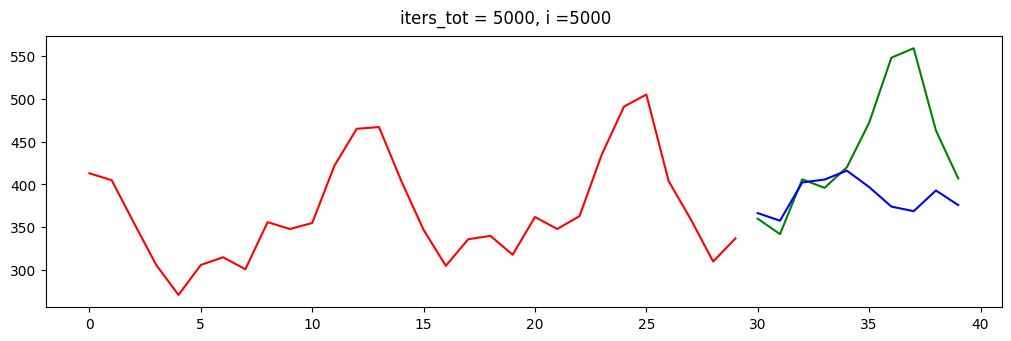

iters_tot = 5001 ; i = 5000 ; last 5 loss values: [3.10e+02, 3.10e+02, 3.10e+02, 3.10e+02, 3.10e+02], minibatches = False


KeyboardInterrupt: 

In [62]:
criterion = nn.MSELoss()
optimizer = Adam(LSTM_custom.parameters(), lr = 1e-6)#, weight_decay=1e-5)
iters_tot = train(  model               = LSTM_custom,
                    model_name          = 'pytorch_custom',
                    criterion           = criterion,
                    optimizer           = optimizer,
                    saved_state_path    = saved_state_path,
                    saved_state_iters   = 999,
                    minibatches         = False,
                    minbatch_size       = 70,
                    NUM_EPOCHS          = 40001,
                    iters_tot           = iters_tot,
                    loss_last_N         = 10,
                    loss_lower_than     = 100,
                    loss_report_interval= 100,
                    eval_interval       = 500,
                    folder_report       = report_folder,
                    dtype               = torch.double)
